In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

path = 'data/input.txt'
text = open(path).read()
print('text length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Using TensorFlow backend.


text length: 501470
total chars: 93


In [41]:
maxlen = 30
sentences = []
next_chars = []
for i in range(0, 100):
    j = random.randint(0, len(text) - maxlen - 1)
    sentences.append(text[j: j + maxlen])
    next_chars.append(text[j + maxlen + 1])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[char]] = 1

val_per = 0.2
X_train = X[int(X.shape[0] * val_per):-1, :, :]
y_train = y[int(X.shape[0] * val_per):-1, :]
X_val = X[1:int(X.shape[0] * val_per), :, :]
y_val = y[1:int(X.shape[0] * val_per), :]

nb sequences: 100
Vectorization...


In [40]:
y_train.shape

(79, 93)

In [4]:
model = Sequential()
model.add(SimpleRNN(100, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [5]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Train on 79 samples, validate on 19 samples
Epoch 1/5
79/79 [==============================] - 2s - loss: 4.5315 - val_loss: 1.4156
Epoch 2/5
79/79 [==============================] - 2s - loss: 4.3087 - val_loss: 0.7488
Epoch 3/5
79/79 [==============================] - 2s - loss: 4.0156 - val_loss: 0.9748
Epoch 4/5
79/79 [==============================] - 2s - loss: 3.9179 - val_loss: 1.4975
Epoch 5/5
79/79 [==============================] - 2s - loss: 3.8286 - val_loss: 0.8082


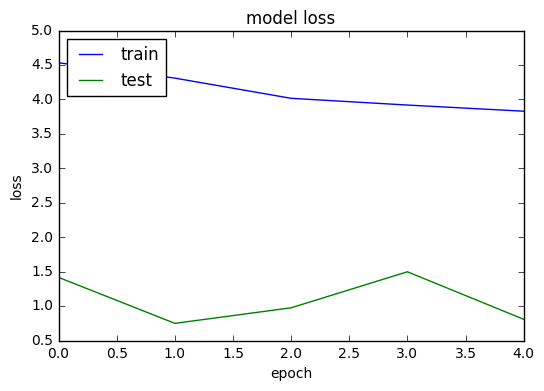


----- diversity: 1.0
----- Generating with seed: ":103
T:La sauteparello (rounde"
:103
T:La sauteparello (roundeeeeei               


In [42]:
history = model.fit(X_train, y_train, batch_size=1, nb_epoch=5, validation_data=(X_val, y_val))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
start_index = random.randint(0, len(text) - maxlen - 1)
for diversity in [1.0]:
    print()
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(20):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()